In [26]:
import tensorflow as tf
import matplotlib.pyplot as plt
import io
from PIL import Image

In [27]:
episodes_dataset = tf.data.TFRecordDataset(
    "gs://rl_unplugged/atari_episodes_ordered/Pong/run_1-00000-of-00050",
    compression_type="GZIP"
)

In [28]:
raw_example = next(iter(episodes_dataset))

example = tf.train.Example()
example.ParseFromString(raw_example.numpy())

print("Features in the TFRecord example:")
for key in example.features.feature.keys():
    feature = example.features.feature[key]
    # Print the type of data stored in this feature
    if feature.bytes_list.value:
        dtype = "bytes"
    elif feature.int64_list.value:
        dtype = "int64"
    elif feature.float_list.value:
        dtype = "float"
    else:
        dtype = "unknown"
    print(f"{key}: {dtype}")

Features in the TFRecord example:
clipped_rewards: float
unclipped_rewards: float
episode_return: float
clipped_episode_return: float
discounts: float
observations: bytes
actions: int64
checkpoint_idx: int64
episode_idx: int64


In [29]:
!git clone https://github.com/Coluding/world-models.git

fatal: destination path 'world-models' already exists and is not an empty directory.


In [30]:
import sys
sys.path.append('/content/world-models')

import torch
from torch.utils.data import Dataset, DataLoader

In [31]:
feature_description = {
  "observations": tf.io.VarLenFeature(tf.string),
  "actions": tf.io.VarLenFeature(tf.int64),
  "clipped_rewards": tf.io.VarLenFeature(tf.float32),
}

def parse_sequence(example_proto):
  parsed = tf.io.parse_single_example(example_proto, feature_description)
  obs = tf.sparse.to_dense(parsed["observations"])
  actions = tf.sparse.to_dense(parsed["actions"])
  rewards = tf.sparse.to_dense(parsed["clipped_rewards"])
  imgs = tf.map_fn(lambda x: tf.io.decode_image(x, channels=3), obs, dtype=tf.uint8)
  #imgs.set_shape([None, 84, 84, 3])
  #imgs = tf.image.resize(imgs, [64, 64])
  imgs = tf.cast(imgs, tf.float32) / 255.0
  actions = tf.cast(actions, tf.int64)
  rewards = tf.cast(rewards, tf.float32)
  return imgs, actions, rewards

sequence_length = 50
batch_size = 16

episodes_dataset = tf.data.TFRecordDataset(
    "gs://rl_unplugged/atari_episodes_ordered/Pong/run_1-00000-of-00050",
    compression_type="GZIP"
)
dataset = episodes_dataset.map(parse_sequence)
dataset = dataset.filter(lambda imgs, actions, rewards: tf.shape(imgs)[0] >= sequence_length)
dataset = dataset.map(lambda imgs, actions, rewards: (
    imgs[:sequence_length], actions[:sequence_length], rewards[:sequence_length]
))
dataset = dataset.batch(batch_size, drop_remainder=True)

(865, 84, 84, 3)
(865,)
(865,)


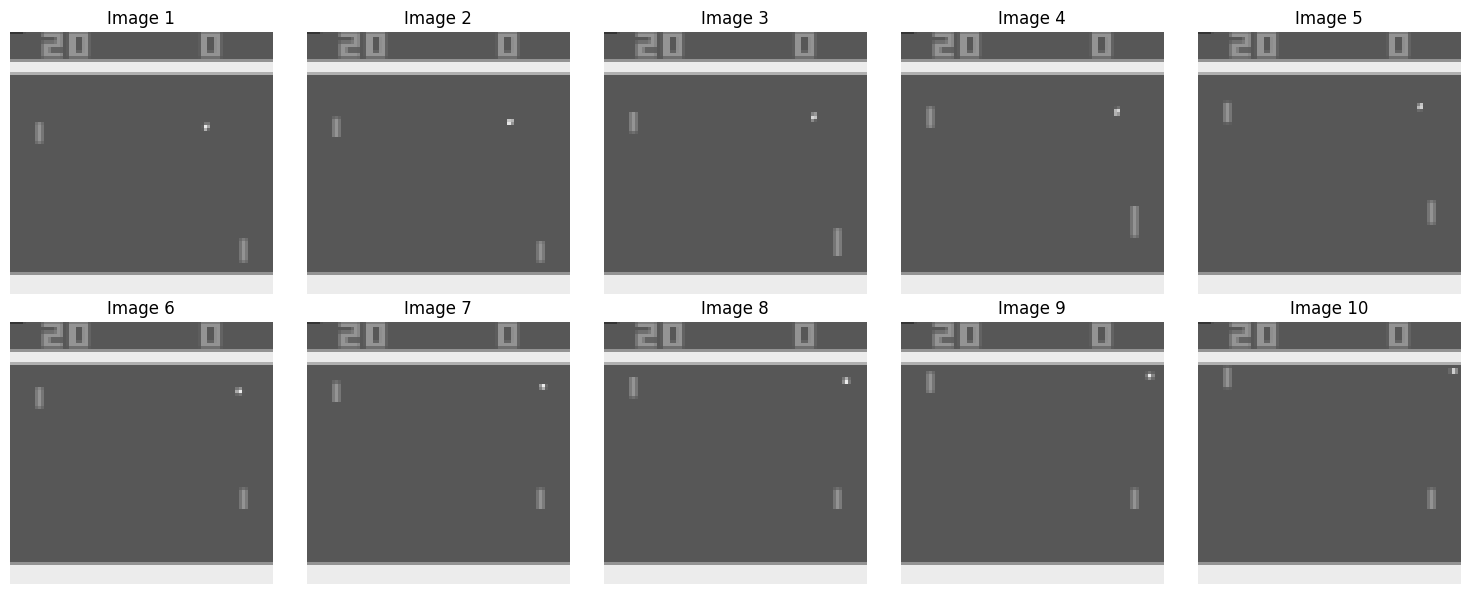

In [32]:

example = next(iter(episodes_dataset.take(1)))
imgs, actions, rewards = parse_sequence(example)

print(imgs.shape)
print(actions.shape)
print(rewards.shape)

last_ten_imgs = imgs[-10:]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
  ax.imshow(last_ten_imgs[i], vmin=0, vmax=1)
  ax.set_title(f"Image {i+1}")
  ax.axis("off")
plt.tight_layout()
plt.show()


In [33]:
for imgs, actions, rewards in dataset.take(1):
  print("imgs:", imgs.shape)
  print("actions:", actions.shape)
  print("rewards:", rewards.shape)

imgs: (16, 50, 84, 84, 3)
actions: (16, 50)
rewards: (16, 50)


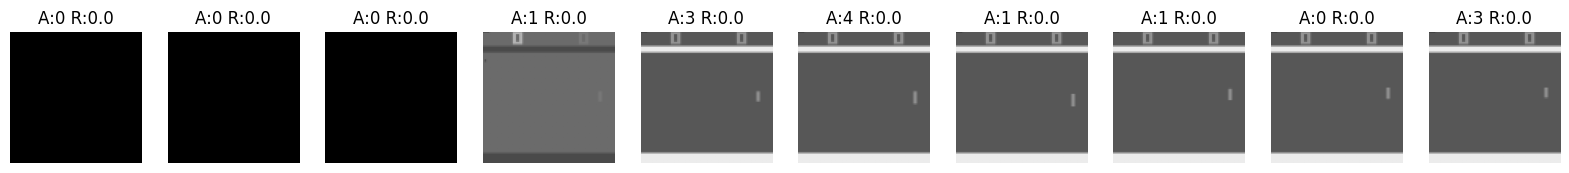

In [34]:
for imgs, actions, rewards in dataset.take(1):
  seq_imgs = imgs[0]
  seq_actions = actions[0]
  seq_rewards = rewards[0]

  plt.figure(figsize=(20, 4))
  for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(seq_imgs[i].numpy())
    plt.axis("off")
    plt.title(f"A:{seq_actions[i].numpy()} R:{seq_rewards[i].numpy():.1f}")
  plt.show()

In [35]:
def parse_sequence_for_inspection(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    obs = tf.sparse.to_dense(parsed["observations"])
    imgs = tf.map_fn(lambda x: tf.io.decode_image(x, channels=3), obs, dtype=tf.uint8)
    print("Original image shape (before resizing):", imgs.shape)
    return imgs

example = next(iter(episodes_dataset.take(1)))
imgs = parse_sequence_for_inspection(example)

Original image shape (before resizing): (865, 84, 84, 3)


In [36]:
from torch.utils.data import Dataset
import numpy as np
import torch

class AtariSequenceDataset(Dataset):
    """
    Wraps a tf.data dataset of Atari episodes and exposes per-sequence items
    for PyTorch. Expects frames to be (T, 84, 84, 3) uint8. If the tf.dataset
    is already batched, this class splits along the batch dim so each __getitem__
    returns a single sequence.
    """
    def __init__(self, tf_dataset, num_batches: int):
        self.data = []
        cnt = 0
        for imgs_tf, actions_tf, rewards_tf in tf_dataset:
            # Materialize this tf batch to NumPy
            imgs_np = imgs_tf.numpy()      # either (B,T,84,84,3) or (T,84,84,3)
            acts_np = actions_tf.numpy()
            rews_np = rewards_tf.numpy()

            if imgs_np.ndim == 5:
                # tf_dataset is batched: split into per-sequence items
                B = imgs_np.shape[0]
                for b in range(B):
                    self._append_one(imgs_np[b], acts_np[b], rews_np[b])
            elif imgs_np.ndim == 4:
                # tf_dataset is unbatched: already one sequence
                self._append_one(imgs_np, acts_np, rews_np)
            else:
                raise ValueError(f"Unexpected imgs ndim: {imgs_np.ndim}")

            cnt += 1
            if cnt >= num_batches:
                break

    def _append_one(self, imgs, actions, rewards):
        # Expect (T,84,84,3) uint8
        if imgs.shape[-3:-1] != (84, 84) or imgs.shape[-1] != 3:
            raise ValueError(f"Expected frames of shape (T,84,84,3), got {imgs.shape}")
        self.data.append((imgs, actions, rewards))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        imgs, actions, rewards = self.data[idx]
        # imgs: (T,84,84,3) uint8 -> float32 in [0,1]
        if imgs.dtype != np.float32:
            imgs = imgs.astype(np.float32) / 255.0

        imgs    = torch.from_numpy(imgs)           # (T,84,84,3) NHWC, [0,1]
        actions = torch.from_numpy(actions).long() # (T,)
        rewards = torch.from_numpy(rewards).float()# (T,)

        return imgs, actions, rewards


In [37]:
# Tune as needed
BATCH_TORCH = 8       # number of sequences per batch
NUM_WORKERS = 2       # >0 for speed; set 0 on Windows/Colab CPU-only
DROP_LAST   = True    # keeps shapes stable

num_batches = 100
atari_dataset = AtariSequenceDataset(dataset, num_batches)

dataloader = DataLoader(
    atari_dataset,
    batch_size=BATCH_TORCH,     # batches sequences: (B, T, 84, 84, 3)
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,            # faster H2D copies
    drop_last=DROP_LAST,
    persistent_workers=(NUM_WORKERS > 0),
    prefetch_factor=2 if NUM_WORKERS > 0 else None,
)
print(f"Loaded {len(atari_dataset)} sequences. Batch size = {BATCH_TORCH}")

Loaded 704 sequences. Batch size = 8


In [38]:
from models.models import EncoderCNN, DecoderCNN, RewardModel
from models.rssm import RSSM
from models.dynamics import DynamicsModel
import torch
import torch.nn.functional as F
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"


action_dim = 6            # keep if you know Pong uses 6 in your dataset
embedding_dim = 1024
hidden_size = 1024
state_size = 30
embedding_size = 16384

# 🔁 64 -> 84 here
encoder = EncoderCNN(
    in_channels=3,
    embedding_dim=embedding_size,
    input_shape=(3, 84, 84)        # <-- changed
).to(device)

decoder_core = DecoderCNN(
    hidden_size, state_size, embedding_size,
    use_bn=True,
    output_shape=(3, 84, 84)       # <-- changed
).to(device)

# Safety wrapper: force exact 84×84 even if core decoder lands off by a pixel
class EnsureHW(nn.Module):
    def __init__(self, base, target_hw=(84,84)):
        super().__init__()
        self.base = base
        self.target_hw = target_hw
    def forward(self, *args, **kwargs):
        y = self.base(*args, **kwargs)
        if y.shape[-2:] != self.target_hw:
            y = F.interpolate(y, size=self.target_hw, mode="bilinear", align_corners=False)
        return y

decoder = EnsureHW(decoder_core, target_hw=(84,84)).to(device)

reward_model   = RewardModel(hidden_size, state_size).to(device)
dynamics_model = DynamicsModel(hidden_size, state_size, action_dim, embedding_size).to(device)

rssm = RSSM(
    encoder, decoder, reward_model, dynamics_model,
    hidden_size, state_size, action_dim, embedding_size,
    device=device
)

optimizer = torch.optim.Adam(rssm.parameters(), lr=1e-3)


# Training JEPA Decoder

In [ ]:
# train_decoder_vjepa2.py
# ---------------------------------------------------------------
# Requires: pip install torch torchvision timm einops tensorflow
# Optional (HF backend): pip install transformers decord (or eva-decord/decord2 on macOS)
# ---------------------------------------------------------------
import os, math, numpy as np, tensorflow as tf
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ---- Config ----
VJEPA_BACKEND = os.environ.get("VJEPA_BACKEND", "hub")   # "hub" or "hf"
USE_AC = bool(int(os.environ.get("VJEPA_USE_AC", "0")))  # 1=use AC variant via hub
HF_REPO = os.environ.get("VJEPA_HF_REPO", "facebook/vjepa2-vitl-fpc64-256")

TFRECORD_PATH = "gs://rl_unplugged/atari_episodes_ordered/Pong/run_1-00000-of-00050"
SEQ_LEN = 50
K_FRAMES = 16
BATCH_TF = 8
BATCH_TORCH = 8
USE_GRAYSCALE = True
EPOCHS = 5
LR = 1e-3
ENCODER_MICROBATCH = 8  # number of frames per encoder call
USE_BF16 = torch.cuda.is_bf16_supported()


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ---------------- TFRecords -> tf.data ----------------
feature_description = {
    "observations": tf.io.VarLenFeature(tf.string),
    "actions": tf.io.VarLenFeature(tf.int64),
    "clipped_rewards": tf.io.VarLenFeature(tf.float32),
}

def _decode_frame(x):
    img = tf.io.decode_image(x, channels=3, expand_animations=False)  # uint8
    # Keep native 84×84; only force if your source isn't 84×84:
    # img = tf.image.resize(img, [84, 84], method="nearest", antialias=False)
    return tf.cast(img, tf.uint8)

def parse_sequence(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    obs = tf.sparse.to_dense(parsed["observations"])
    acts = tf.sparse.to_dense(parsed["actions"])
    rews = tf.sparse.to_dense(parsed["clipped_rewards"])
    imgs = tf.map_fn(_decode_frame, obs, fn_output_signature=tf.uint8)  # (T,84,84,3)
    return imgs, tf.cast(acts, tf.int64), tf.cast(rews, tf.float32)


episodes_dataset = tf.data.TFRecordDataset(TFRECORD_PATH, compression_type="GZIP")
dataset = (episodes_dataset
           .map(parse_sequence, num_parallel_calls=tf.data.AUTOTUNE)
           .filter(lambda im, a, r: tf.shape(im)[0] >= SEQ_LEN)
           .map(lambda im, a, r: (im[:SEQ_LEN], a[:SEQ_LEN], r[:SEQ_LEN]))
           .batch(BATCH_TF, drop_remainder=True)
           .prefetch(tf.data.AUTOTUNE))

# ------------- Bridge to PyTorch per-sequence items -------------
class AtariSequenceDataset(Dataset):
    def __init__(self, tf_dataset, num_tf_batches: int):
        self.frames, self.actions, self.rewards = [], [], []
        cnt = 0
        for imgs_tf, acts_tf, rews_tf in tf_dataset:
            B = imgs_tf.shape[0]
            imgs = imgs_tf.numpy().astype(np.uint8)  # (B,T,84,84,3)
            acts = acts_tf.numpy()
            rews = rews_tf.numpy()
            for b in range(B):
                self.frames.append(imgs[b])           # (T,84,84,3)
                self.actions.append(acts[b])
                self.rewards.append(rews[b])
            cnt += 1
            if cnt >= num_tf_batches:
                break
    def __len__(self): return len(self.frames)
    def __getitem__(self, idx):
        imgs = torch.from_numpy(self.frames[idx].astype(np.float32) / 255.0)  # (T,84,84,3)
        acts = torch.from_numpy(self.actions[idx]).long()
        rews = torch.from_numpy(self.rewards[idx]).float()
        return imgs, acts, rews

NUM_TF_BATCHES_TO_LOAD = int(os.environ.get("NUM_TF_BATCHES", "100"))
pt_dataset = AtariSequenceDataset(dataset, NUM_TF_BATCHES_TO_LOAD)
pt_loader = DataLoader(pt_dataset, batch_size=BATCH_TORCH, shuffle=True, num_workers=0, drop_last=True)
print(f"Loaded {len(pt_dataset)} sequences.")

# -------------------- Load V-JEPA 2 (hub or HF) --------------------
preprocessor = None
vjepa_model = None
vjepa_ac_predictor = None

if VJEPA_BACKEND == "hub":
    # Requires timm + einops installed
    preprocessor = torch.hub.load('facebookresearch/vjepa2', 'vjepa2_preprocessor')
    if USE_AC:
        obj = torch.hub.load('facebookresearch/vjepa2', 'vjepa2_ac_vit_giant')
        # AC returns (encoder, predictor)
        if isinstance(obj, tuple):
            vjepa_model, vjepa_ac_predictor = obj[0], obj[1]
        else:
            vjepa_model = obj
        print("Loaded V-JEPA 2-AC (ViT-g) from hub.")
    else:
        obj = torch.hub.load('facebookresearch/vjepa2', 'vjepa2_vit_large')
        vjepa_model = obj[0] if isinstance(obj, tuple) else obj
        print("Loaded V-JEPA 2 (ViT-L) from hub.")

    vjepa_model.to(device).eval()
    for p in vjepa_model.parameters(): p.requires_grad_(False)

elif VJEPA_BACKEND == "hf":
    from transformers import AutoVideoProcessor, AutoModel
    vjepa_model = AutoModel.from_pretrained(HF_REPO).to(device).eval()
    preprocessor = AutoVideoProcessor.from_pretrained(HF_REPO)
    for p in vjepa_model.parameters(): p.requires_grad_(False)
    print(f"Loaded {HF_REPO} from Hugging Face.")
else:
    raise ValueError("VJEPA_BACKEND must be 'hub' or 'hf'.")

# -------------------- frames -> tokens helper --------------------
# --- infer spatial grid (unchanged) ------------------------------------------
def _infer_grid_hw():
    if hasattr(vjepa_model, "patch_embed"):
        pe = vjepa_model.patch_embed
        if hasattr(pe, "grid_size") and pe.grid_size is not None:
            gs = pe.grid_size
            if isinstance(gs, (tuple, list)) and len(gs) == 2:
                return int(gs[0]), int(gs[1])
        # fallback: patch size + target resize
        patch = None
        if hasattr(pe, "patch_size"):
            ps = pe.patch_size
            patch = int(ps[0]) if isinstance(ps, (tuple, list)) else int(ps)
        target = 256
        return (target // patch, target // patch) if patch and target % patch == 0 else (16, 16)
    return 16, 16

# --- NEW: infer temporal settings --------------------------------------------
def _infer_temporal_T_and_tubelet():
    """Return (T_in, tubelet_t). Default to (16, 2) if not found."""
    T_in, tubelet_t = 16, 2
    pe = getattr(vjepa_model, "patch_embed", None)
    if pe is not None:
        # Common names in timm-style video ViTs
        if hasattr(pe, "tubelet_size"):
            ts = pe.tubelet_size  # e.g., (2, 16, 16)
            if isinstance(ts, (tuple, list)) and len(ts) >= 1:
                tubelet_t = int(ts[0])
        if hasattr(vjepa_model, "num_frames"):
            try:
                T_in = int(vjepa_model.num_frames)
            except Exception:
                pass
    return T_in, tubelet_t

# --- REPLACE frames_to_tokens (hub branch) -----------------------------------
@torch.no_grad()
def clips_to_center_tokens(frames_bkchw: torch.Tensor, override_T_in: int = None) -> torch.Tensor:
    """
    frames_bkchw: (B, K, C, 84, 84) in [0,1]
    Returns: (B, K, D, Ht, Wt) tokens aligned per frame using a T_in-length window centered on each t.
    If the model expects T_in > K, we clamp-repeat boundary frames to reach T_in.
    """
    B, K, C, H, W = frames_bkchw.shape
    Ht_exp, Wt_exp = _infer_grid_hw()
    spatial_tokens = Ht_exp * Wt_exp

    T_model, _ = _infer_temporal_T_and_tubelet()  # e.g., 64 on some builds
    T_in = override_T_in if override_T_in is not None else T_model
    dtype_amp = torch.bfloat16 if USE_BF16 else torch.float16

    if not hasattr(clips_to_center_tokens, "_printed"):
        print(f"[clips_to_center_tokens] Using T_in={T_in} (model reported {T_model}), K={K}")
        clips_to_center_tokens._printed = True

    tokens_per_t = []

    for t in range(K):
        # 1) Build clamped index window of length T_in centered on t
        start = t - (T_in // 2)
        idx = torch.arange(start, start + T_in, device=frames_bkchw.device)
        idx = idx.clamp(0, K - 1)                                  # (T_in,)

        # Gather -> (B, T_in, C, H, W)
        clip = frames_bkchw.index_select(1, idx)

        # 2) Preprocess each frame to (C,256,256), then pack to (B,C,T_in,256,256)
        # (B,T_in,C,H,W) -> (B*T_in,C,H,W)
        clip_btchw = clip.reshape(B * T_in, C, H, W)

        proc_list = []
        for f in clip_btchw:                                       # f: (C,H,W), float [0,1]
            out = preprocessor([f.cpu()])
            out = out[0] if isinstance(out, (list, tuple)) else out
            # Ensure (C,256,256)
            if out.dim() == 4:                                     # rare: (C,T,256,256)
                out = out[:, 0]
            proc_list.append(out)

        proc = torch.stack(proc_list, dim=0)                       # (B*T_in, C, 256, 256)
        proc = proc.view(B, T_in, C, 256, 256).permute(0, 2, 1, 3, 4).contiguous()  # (B,C,T_in,256,256)
        del proc_list, clip_btchw, clip

        # 3) Run the encoder in micro-batches over B
        toks_chunks = []
        for s in range(0, B, ENCODER_MICROBATCH):
            e = min(B, s + ENCODER_MICROBATCH)
            mb_clip = proc[s:e].to(device, non_blocking=True)      # (b,C,T_in,256,256)
            with torch.autocast(device_type="cuda", dtype=dtype_amp):
                out = vjepa_model(mb_clip)

            # Normalize model outputs to a common tensor x
            if isinstance(out, (list, tuple)) and len(out) > 0:
                x = out[0]
            elif isinstance(out, dict):
                for k in ("x", "feats", "last_hidden_state", "tokens"):
                    if k in out:
                        x = out[k]; break
                else:
                    x = next(iter(out.values()))
            else:
                x = out

            # 4) If time dimension present -> pick center time
            if x.dim() == 4:                                       # (b, T', N, D)
                b, Tprime, N, D = x.shape
                x = x[:, Tprime // 2]                              # -> (b, N, D)
            elif x.dim() == 3:                                     # (b, N, D)
                b, N, D = x.shape
            else:
                raise RuntimeError(f"Unexpected V-JEPA output shape: {tuple(x.shape)}")

            # 5) Handle multiple spatial groups along N
            spatial = spatial_tokens                                # Ht*Wt
            if N % spatial == 0:
                G = N // spatial
                if G > 1:
                    x = x.view(b, G, spatial, D)
                    x = x[:, G // 2]                               # pick center group -> (b, spatial, D)
            else:
                # Truncate / pad to reach exactly spatial tokens
                take = min(N, spatial)
                x = x[:, :take, :]
                pad = spatial - take
                if pad > 0:
                    x = torch.cat([x, x[:, -1:, :].expand(b, pad, D)], dim=1)

            # 6) Fold to (b, D, Ht, Wt)
            toks = x.view(b, Ht_exp, Wt_exp, D).permute(0, 3, 1, 2).contiguous()
            toks_chunks.append(toks)

            del mb_clip, out, x, toks

        toks_t = torch.cat(toks_chunks, dim=0)                     # (B, D, Ht, Wt)
        tokens_per_t.append(toks_t)
        del proc

    tokens_bk = torch.stack(tokens_per_t, dim=1)                   # (B, K, D, Ht, Wt)
    return tokens_bk




# -------------------- Decoder head --------------------
class TokenNorm(nn.Module):
    def __init__(self, d, groups=32, eps=1e-6):
        super().__init__()
        self.gn = nn.GroupNorm(min(groups, d), d, eps=eps, affine=True)
    def forward(self, x):  # (N,D,H,W)
        return self.gn(x)

def add_xy_coords(x):      # x: (N,D,H,W) -> (N,D+2,H,W)
    N, D, H, W = x.shape
    yy, xx = torch.meshgrid(
        torch.linspace(-1, 1, H, device=x.device, dtype=x.dtype),
        torch.linspace(-1, 1, W, device=x.device, dtype=x.dtype),
        indexing="ij"
    )
    coords = torch.stack([yy, xx], dim=0).expand(N, -1, -1, -1)   # (N,2,H,W)
    return torch.cat([x, coords], dim=1)

def make_upsampler(in_ch: int, out_ch: int, h_tokens: int, w_tokens: int) -> nn.Sequential:
    assert h_tokens == w_tokens, "Expect square token grid."
    layers = [nn.Conv2d(in_ch, 256, 1), nn.ReLU(inplace=True)]
    curr = h_tokens
    ch = 256
    while curr < 84:                                  # 84 target
        next_ch = max(64, ch // 2)
        layers += [nn.ConvTranspose2d(ch, next_ch, 4, 2, 1), nn.ReLU(inplace=True)]
        ch = next_ch
        curr *= 2
    layers += [nn.Conv2d(ch, out_ch, 3, padding=1), nn.Sigmoid()]
    return nn.Sequential(*layers)

class VJEPADecoder(nn.Module):
    def __init__(self, d: int, h_tokens: int, w_tokens: int, out_ch: int = 1, use_xy: bool = True):
        super().__init__()
        self.use_xy = use_xy
        self.tok_norm = TokenNorm(d)
        self.net = make_upsampler(d + (2 if use_xy else 0), out_ch, h_tokens, w_tokens)
    def forward(self, tokens: torch.Tensor) -> torch.Tensor:     # (N,D,Ht,Wt)
        x = self.tok_norm(tokens)
        if self.use_xy:
            x = add_xy_coords(x)
        out = self.net(x)                                        # (N,out_ch,~,~)
        if out.shape[-2:] != (84, 84):
            out = F.interpolate(out, size=(84, 84), mode="bilinear", align_corners=False)
        return out

@torch.no_grad()
def probe_token_shape():
    dummy = torch.rand(2, 4, 3, 84, 84, device=device)  # (B=2,K=4,C,H,W)
    toks_bk = clips_to_center_tokens(dummy, override_T_in=16)
    b, k, d, ht, wt = toks_bk.shape
    print(f"[probe] token shape per frame: (D,Ht,Wt)=({d},{ht},{wt})")
    return (d, ht, wt)


D_tok, Ht, Wt = probe_token_shape()
decoder = VJEPADecoder(D_tok, Ht, Wt, out_ch=1 if USE_GRAYSCALE else 3).to(device)
opt = torch.optim.Adam(decoder.parameters(), lr=LR)

def _sobel_edges(img):  # img: (N,1,84,84)
    Kx = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], dtype=img.dtype, device=img.device).view(1,1,3,3)
    Ky = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]], dtype=img.dtype, device=img.device).view(1,1,3,3)
    gx = F.conv2d(img, Kx, padding=1)
    gy = F.conv2d(img, Ky, padding=1)
    return torch.sqrt(gx*gx + gy*gy + 1e-6)

def charbonnier(x, y, eps=1e-3):
    return torch.mean(torch.sqrt((x - y)**2 + eps**2))

def _soft_edges01(img):
    # Sobel -> [0,1] per image for stability
    e = _sobel_edges(img)                               # (N,1,H,W)
    e = e / (e.amax(dim=(-1,-2), keepdim=True) + 1e-6)
    return e.clamp(0, 1)

def recon_loss(pred, tgt, edge_w=0.15, dice_w=0.25, topk_p=0.10):
    # pred,tgt: (N,1,H,W) in [0,1]
    # 1) base pixel loss (robust)
    l_pix = 0.5*charbonnier(pred, tgt) + 0.5*F.l1_loss(pred, tgt)

    # 2) Top-k pixel emphasis (focuses on small, hard regions like the paddle)
    diff = (pred - tgt).abs().flatten(1)                # (N, H*W)
    k = max(1, int(topk_p * diff.size(1)))
    l_topk = diff.topk(k, dim=1).values.mean()

    # 3) Edge focal + soft-Dice on edges (treat edges like a segmentation map)
    pe, te = _soft_edges01(pred), _soft_edges01(tgt)    # (N,1,H,W)
    bce = F.binary_cross_entropy(pe, te, reduction='none')
    p_t = pe*te + (1-pe)*(1-te)                         # agreement
    focal = ((1 - p_t)**2) * bce                        # gamma=2
    smooth = 1e-4
    inter = (pe*te).sum(dim=(1,2,3))
    union = pe.sum(dim=(1,2,3)) + te.sum(dim=(1,2,3))
    dice = 1 - (2*inter + smooth) / (union + smooth)

    return l_pix + 0.5*l_topk + edge_w*focal.mean() + dice_w*dice.mean()


# -------------------- Training loop --------------------
decoder.train()
for epoch in range(1, EPOCHS + 1):
    running = 0.0
    for imgs, acts, rews in pt_loader:
        # imgs: (B, T, 84, 84, 3) -> (B,K,3,84,84)
        imgs = imgs[:, :K_FRAMES].permute(0, 1, 4, 2, 3).contiguous().to(device)  # (B,K,3,84,84)
        frames = imgs.reshape(-1, 3, 84, 84)                                      # for targets below

        # 1) luminance grayscale targets
        if USE_GRAYSCALE:
            frames_gray = (0.299*frames[:,0:1] + 0.587*frames[:,1:2] + 0.114*frames[:,2:3]).contiguous()
            frames_rgb  = frames_gray.repeat(1, 3, 1, 1)
            targets     = frames_gray
        else:
            frames_rgb = frames
            targets    = frames

        # 2) real temporal tokens
        with torch.no_grad():
            toks_bk = clips_to_center_tokens(imgs)        # (B,K,D,Ht,Wt)  <-- uses imgs (not frames_rgb)
        tokens = toks_bk.reshape(-1, toks_bk.size(2), toks_bk.size(3), toks_bk.size(4))  # (B*K,D,Ht,Wt)

        # 3) decode + loss
        preds = decoder(tokens)       # (B*K,1 or 3, 84,84)
        loss  = recon_loss(preds, targets)

        opt.zero_grad()
        loss.backward()
        opt.step()

        running += loss.item()



    print(f"Epoch {epoch}/{EPOCHS} | recon: {running/len(pt_loader):.4f}")

print("Done.")


Using device: cuda
Loaded 704 sequences.


Using cache found in /root/.cache/torch/hub/facebookresearch_vjepa2_main
Using cache found in /root/.cache/torch/hub/facebookresearch_vjepa2_main


Loaded V-JEPA 2 (ViT-L) from hub.
[clips_to_center_tokens] Using T_in=16 (model reported 64), K=4
[probe] token shape per frame: (D,Ht,Wt)=(1024,16,16)


# Reconstruction

In [ ]:
# === EVAL / VISUALIZATION (84x84) ===
import os
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch

decoder.eval()

@torch.no_grad()
def psnr(pred, target, eps=1e-8):
    # pred/target in [0,1], shape (N,1,84,84)
    mse = torch.mean((pred - target) ** 2, dim=(1,2,3)) + eps
    return 10.0 * torch.log10(1.0 / mse)

@torch.no_grad()
def ssim_simple(x, y, C1=0.01**2, C2=0.03**2):
    """
    Fast SSIM approx (no Gaussian window), but with the correct variance formula.
    x,y: (N,1,H,W) in [0,1]
    """
    mu_x = torch.mean(x, dim=(2,3), keepdim=True)
    mu_y = torch.mean(y, dim=(2,3), keepdim=True)
    x_mu = x - mu_x
    y_mu = y - mu_y
    sigma_x2 = torch.mean(x_mu * x_mu, dim=(2,3), keepdim=True)
    sigma_y2 = torch.mean(y_mu * y_mu, dim=(2,3), keepdim=True)
    sigma_xy = torch.mean(x_mu * y_mu, dim=(2,3), keepdim=True)

    num = (2*mu_x*mu_y + C1) * (2*sigma_xy + C2)
    den = (mu_x**2 + mu_y**2 + C1) * (sigma_x2 + sigma_y2 + C2)
    ssim_map = num / (den + 1e-12)
    return ssim_map.view(ssim_map.shape[0])

# --- Grab ONE minibatch of sequences ---
imgs_b, acts_b, rews_b = next(iter(pt_loader))                     # (B,T,84,84,3) in [0,1]
imgs_b = imgs_b[:, :K_FRAMES].permute(0,1,4,2,3).contiguous().to(device)  # (B,K,3,84,84)

# Build targets (luminance) at 84x84
frames = imgs_b.reshape(-1, 3, 84, 84)                             # (B*K,3,84,84)
frames_gray = (0.299*frames[:,0:1] + 0.587*frames[:,1:2] + 0.114*frames[:,2:3]).contiguous()  # (B*K,1,84,84)

# --- Tokens via clips (preferred), fallback to per-frame if helper not defined ---
with torch.no_grad():
    try:
        toks_bk = clips_to_center_tokens(imgs_b)                   # (B,K,D,Ht,Wt)
        tokens  = toks_bk.reshape(-1, toks_bk.size(2), toks_bk.size(3), toks_bk.size(4))
    except NameError:
        # fallback: per-frame tokens using grayscale triplicated as RGB
        frames_rgb = frames_gray.repeat(1, 3, 1, 1)                # (B*K,3,84,84)
        tokens = frames_to_tokens(frames_rgb)                      # (B*K,D,Ht,Wt)

    recons = decoder(tokens).clamp(0,1)                            # (B*K,1 or 3,84,84)

# If decoder outputs 3ch but targets are 1ch, convert recon to 1ch for metrics
if recons.size(1) == 3:
    recons_mono = (0.299*recons[:,0:1] + 0.587*recons[:,1:2] + 0.114*recons[:,2:3]).contiguous()
else:
    recons_mono = recons

# Metrics
psnr_vals = psnr(recons_mono, frames_gray)
ssim_vals = ssim_simple(recons_mono, frames_gray)
print(f"PSNR: {psnr_vals.mean().item():.2f} dB  |  SSIM: {ssim_vals.mean().item():.3f}")

# Visuals: GT on top row, Recon bottom row
Nshow = min(8, recons_mono.shape[0])
gt_grid   = vutils.make_grid(frames_gray[:Nshow], nrow=Nshow, pad_value=1.0)
rec_grid  = vutils.make_grid(recons_mono[:Nshow], nrow=Nshow, pad_value=1.0)
stacked   = torch.cat([gt_grid, rec_grid], dim=1)  # vertical stack (C, H*2, W)

plt.figure(figsize=(Nshow*1.5, 3))
plt.imshow(stacked.permute(1,2,0).cpu().numpy(), vmin=0, vmax=1)
plt.axis('off')
plt.title("Top: Ground Truth  |  Bottom: Reconstruction")
plt.show()

# (Optional) Difference heatmap (absolute error)
diff_grid = vutils.make_grid((frames_gray[:Nshow] - recons_mono[:Nshow]).abs(), nrow=Nshow, pad_value=1.0)
plt.figure(figsize=(Nshow*1.5, 1.5))
plt.imshow(diff_grid.permute(1,2,0).cpu().numpy(), vmin=0, vmax=1)
plt.axis('off')
plt.title("Absolute Error")
plt.show()

os.makedirs("vjepa2_decoder_eval", exist_ok=True)
plt.imsave("vjepa2_decoder_eval/gt_rec_grid_84.png", stacked.permute(1,2,0).cpu().numpy(), vmin=0, vmax=1)
plt.imsave("vjepa2_decoder_eval/diff_grid_84.png", diff_grid.permute(1,2,0).cpu().numpy(), vmin=0, vmax=1)
print("Saved grids to vjepa2_decoder_eval/*.png")


In [ ]:
# === EVAL / VISUALIZATION ===
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch

decoder.eval()

@torch.no_grad()
def psnr(pred, target, eps=1e-8):
    # pred/target in [0,1], shape (N,1,64,64)
    mse = torch.mean((pred - target) ** 2, dim=(1,2,3)) + eps
    return 10.0 * torch.log10(1.0 / mse)

# Simple SSIM (grayscale), gaussian-less approx for quick sanity checks
def ssim_simple(x, y, C1=0.01**2, C2=0.03**2):
    # x,y: (N,1,H,W) in [0,1]
    mu_x = torch.mean(x, dim=(2,3), keepdim=True)
    mu_y = torch.mean(y, dim=(2,3), keepdim=True)
    sigma_x = torch.var(x, dim=(2,3), unbiased=False, keepdim=True)
    sigma_y = torch.var(y, dim=(2,3), unbiased=False, keepdim=True)
    sigma_xy = torch.mean((x - mu_x) * (y - mu_y), dim=(2,3), keepdim=True)

    num = (2*mu_x*mu_y + C1) * (2*sigma_xy + C2)
    den = (mu_x**2 + mu_y**2 + C1) * (sigma_x + sigma_y + C2)
    ssim_map = num / den
    return ssim_map.view(ssim_map.shape[0])

# Grab ONE minibatch of sequences
imgs_b, acts_b, rews_b = next(iter(pt_loader))  # imgs_b: (B,T,64,64,3) in [0,1]
imgs_b = imgs_b[:, :K_FRAMES].permute(0,1,4,2,3).contiguous().to(device)  # (B,K,3,64,64)
frames = imgs_b.reshape(-1, 3, 64, 64)  # (B*K,3,64,64)

# Build RGB (for encoder) & grayscale target (for recon)
frames_gray = torch.mean(frames, dim=1, keepdim=True)           # (B*K,1,64,64)
frames_rgb  = frames_gray.repeat(1, 3, 1, 1)                    # (B*K,3,64,64)

with torch.no_grad():
    tokens = frames_to_tokens(frames_rgb)                       # (B*K, D, H', W')
    recons = decoder(tokens)                                    # (B*K,1,64,64)

# Metrics
psnr_vals = psnr(recons, frames_gray)
ssim_vals = ssim_simple(recons, frames_gray)
print(f"PSNR: {psnr_vals.mean().item():.2f} dB  |  SSIM: {ssim_vals.mean().item():.3f}")

# Make a small grid: 8 GTs over 8 RECONs
Nshow = min(8, recons.shape[0])
gt_grid   = vutils.make_grid(frames_gray[:Nshow], nrow=Nshow, pad_value=1.0)
rec_grid  = vutils.make_grid(recons[:Nshow],      nrow=Nshow, pad_value=1.0)
stacked   = torch.cat([gt_grid, rec_grid], dim=1)  # vertical concat (C,H*2,W)

plt.figure(figsize=(Nshow*1.5, 3))
plt.imshow(stacked.permute(1,2,0).cpu().numpy(), vmin=0, vmax=1)
plt.axis('off')
plt.title("Top: Ground Truth  |  Bottom: Reconstruction")
plt.show()

os.makedirs("vjepa2_decoder_eval", exist_ok=True)
plt.imsave("vjepa2_decoder_eval/gt_rec_grid.png", stacked.permute(1,2,0).cpu().numpy(), vmin=0, vmax=1)
print("Saved grid to vjepa2_decoder_eval/gt_rec_grid.png")



=== Per-frame stats for first 8 frames ===
[0] GT:  min=0.2863 max=0.6902 mean=0.4033 std=0.0445 | REC: min=0.2775 max=0.6915 mean=0.4004 std=0.0440 | |REC-GT|: min=0.0000 max=0.1376 mean=0.0036 std=0.0045
[1] GT:  min=0.2431 max=0.9255 mean=0.4151 std=0.1793 | REC: min=0.2201 max=0.9309 mean=0.4115 std=0.1815 | |REC-GT|: min=0.0000 max=0.1890 mean=0.0045 std=0.0091
[2] GT:  min=0.2431 max=0.9255 mean=0.4153 std=0.1793 | REC: min=0.2201 max=0.9309 mean=0.4115 std=0.1815 | |REC-GT|: min=0.0000 max=0.1921 mean=0.0046 std=0.0105
[3] GT:  min=0.2431 max=0.9255 mean=0.4151 std=0.1793 | REC: min=0.2201 max=0.9309 mean=0.4115 std=0.1815 | |REC-GT|: min=0.0000 max=0.1917 mean=0.0044 std=0.0088
[4] GT:  min=0.2431 max=0.9255 mean=0.4151 std=0.1793 | REC: min=0.2201 max=0.9309 mean=0.4115 std=0.1815 | |REC-GT|: min=0.0000 max=0.1921 mean=0.0045 std=0.0094
[5] GT:  min=0.2431 max=0.9255 mean=0.4150 std=0.1793 | REC: min=0.2201 max=0.9309 mean=0.4115 std=0.1815 | |REC-GT|: min=0.0000 max=0.1921 m

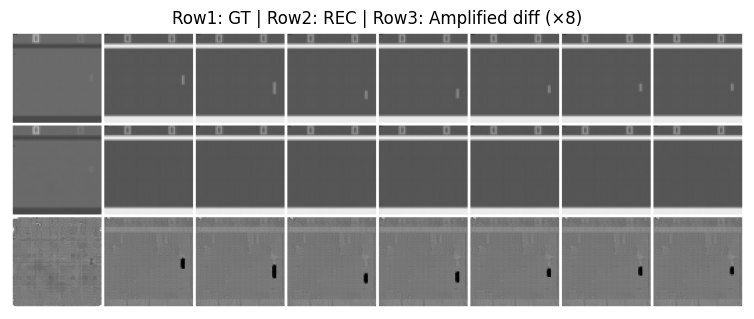

Saved grid to vjepa2_decoder_eval/gt_rec_amp_grid.png


In [ ]:
# --- Inspect first 8 frames numerically & visually ---
import numpy as np, os, matplotlib.pyplot as plt, torchvision.utils as vutils
torch.set_printoptions(precision=4, sci_mode=False, linewidth=160)

N = min(8, recons.shape[0])
gt32  = frames_gray.squeeze(1).float().cpu()[:N]   # (N,64,64)
rec32 = recons.squeeze(1).float().cpu()[:N]        # (N,64,64)
diff  = (rec32 - gt32).abs()

def stats(x):
    xnp = x.numpy()
    return f"min={xnp.min():.4f} max={xnp.max():.4f} mean={xnp.mean():.4f} std={xnp.std():.4f}"

def sobel_mag(img):  # img: (64,64) float
    kx = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], dtype=img.dtype)
    ky = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]], dtype=img.dtype)
    gx = torch.conv2d(img[None,None], kx[None,None], padding=1)[0,0]
    gy = torch.conv2d(img[None,None], ky[None,None], padding=1)[0,0]
    return torch.sqrt(gx*gx + gy*gy + 1e-6)

def crop(arr, y, x, r=5):
    y0, y1 = max(0,y-r), min(64,y+r)
    x0, x1 = max(0,x-r), min(64,x+r)
    return arr[y0:y1, x0:x1].numpy(), (y0,y1,x0,x1)

save_dir = "vjepa2_decoder_eval/arrays"
os.makedirs(save_dir, exist_ok=True)

print("\n=== Per-frame stats for first", N, "frames ===")
for i in range(N):
    print(f"[{i}] GT:  {stats(gt32[i])} | REC: {stats(rec32[i])} | |REC-GT|: {stats(diff[i])}")

print("\n=== 10x10 crops around strongest GT edge (likely paddle) ===")
for i in range(N):
    edge = sobel_mag(gt32[i])
    iy, ix = torch.nonzero(edge == edge.max(), as_tuple=True)
    iy, ix = int(iy[0]), int(ix[0])
    gt_crop, box  = crop(gt32[i],  iy, ix, r=5)
    rec_crop, _   = crop(rec32[i], iy, ix, r=5)
    dif_crop, _   = crop(diff[i],  iy, ix, r=5)
    print(f"\nFrame {i} @ (y={iy}, x={ix}) box={box}")
    print("GT crop:\n",  np.array_str(gt_crop,  precision=3))
    print("REC crop:\n", np.array_str(rec_crop, precision=3))
    print("|REC-GT| crop:\n", np.array_str(dif_crop, precision=4))

    # Save full arrays + crops
    np.savetxt(f"{save_dir}/gt_frame{i}.csv",  gt32[i].numpy(),  delimiter=",")
    np.savetxt(f"{save_dir}/rec_frame{i}.csv", rec32[i].numpy(),  delimiter=",")
    np.savetxt(f"{save_dir}/diff_frame{i}.csv", diff[i].numpy(),  delimiter=",")
    np.savetxt(f"{save_dir}/gt_crop_frame{i}.csv",  gt_crop,  delimiter=",")
    np.savetxt(f"{save_dir}/rec_crop_frame{i}.csv", rec_crop, delimiter=",")
    np.savetxt(f"{save_dir}/diff_crop_frame{i}.csv", dif_crop, delimiter=",")

print(f"\nSaved CSVs to {save_dir}")

# Visual: grid of GT / REC / amplified diff for first N frames
amp = 8.0
gt_vis  = gt32.unsqueeze(1)                 # (N,1,64,64)
rec_vis = rec32.unsqueeze(1)                # (N,1,64,64)
amp_vis = torch.clamp((rec32 - gt32) * amp + 0.5, 0, 1).unsqueeze(1)

grid = torch.cat([gt_vis, rec_vis, amp_vis], dim=0)  # 3N images
grid = vutils.make_grid(grid, nrow=N, pad_value=1.0) # rows: GT | REC | AMPDIFF
plt.figure(figsize=(N*1.2, 3.6))
plt.imshow(grid.permute(1,2,0).numpy(), vmin=0, vmax=1, cmap="gray")
plt.axis('off'); plt.title("Row1: GT | Row2: REC | Row3: Amplified diff (×{:.0f})".format(amp))
plt.show()

os.makedirs("vjepa2_decoder_eval", exist_ok=True)
plt.imsave("vjepa2_decoder_eval/gt_rec_amp_grid.png", grid.permute(1,2,0).numpy(), vmin=0, vmax=1, cmap="gray")
print("Saved grid to vjepa2_decoder_eval/gt_rec_amp_grid.png")
